<a href="https://colab.research.google.com/github/estherpadrao/dummy-city-data/blob/main/Capstone_MVP_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

City Model with Nearest OSM Nodes:
       zone_id      lat      lon         type                   geometry  \
0    Warehouse -34.6083 -58.3625    warehouse  POINT (-58.3625 -34.6083)   
1  Residential -34.6155 -58.3687  residential  POINT (-58.3687 -34.6155)   
2     Hospital -34.6095 -58.3730     hospital   POINT (-58.373 -34.6095)   

   nearest_node  
0     310376935  
1     194502593  
2     256032725  
KPI Summary Table:
       Scenario  Avg Delivery Time
0          Base        1336.565917
1  Road Blocked        1852.598511


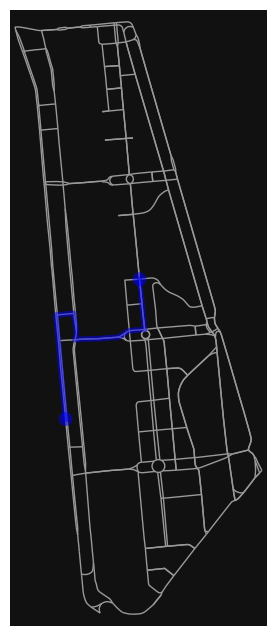

In [23]:
# MVP Simulation Pipeline with Scenario Planning, OSM Routing, and Mapping

import pandas as pd
import networkx as nx
import simpy
import folium
import geopandas as gpd
from shapely.geometry import Point
import osmnx as ox
import matplotlib.pyplot as plt


place = "Puerto Madero, Buenos Aires, Argentina"
G = ox.graph_from_place(place, network_type='drive')

zones = pd.DataFrame({
    'zone_id': ['Warehouse', 'Residential', 'Hospital'],
    'lat': [-34.6083, -34.6155, -34.6095],
    'lon': [-58.3625, -58.3687, -58.3730],
    'type': ['warehouse', 'residential', 'hospital']
})

zones['geometry'] = zones.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
gdf = gpd.GeoDataFrame(zones, geometry='geometry', crs="EPSG:4326")
zones['nearest_node'] = zones.apply(lambda row: ox.distance.nearest_nodes(G, row['lon'], row['lat']), axis=1)
print("City Model with Nearest OSM Nodes:")
print(zones)


# Pathfinding with Scenario Planning

def get_route(G, source, target, scenario="base"):
    G_copy = G.copy()
    if scenario == "road_blocked":
        # First find the normal shortest path
        try:
            normal_path = nx.shortest_path(G_copy, source=source, target=target, weight='length')
        except nx.NetworkXNoPath:
            print("No path available even in base scenario.")
            return [], float('inf')

        # Block one critical edge (e.g., the first edge in the path)
        if len(normal_path) > 1:
            u, v = normal_path[0], normal_path[1]  # first edge in the path
            edges_to_remove = [(x, y, k) for x, y, k in G_copy.edges(keys=True) if (x == u and y == v) or (x == v and y == u)]
            for x, y, k in edges_to_remove:
                G_copy.remove_edge(x, y, k)
        else:
            print("Path too short to block an edge.")

    try:
        path = nx.shortest_path(G_copy, source=source, target=target, weight='length')
        length = nx.shortest_path_length(G_copy, source=source, target=target, weight='length')
    except nx.NetworkXNoPath:
        print(f"No path available from {source} to {target} under scenario {scenario}.")
        path, length = [], float('inf')
    return path, length


source = zones.loc[zones['zone_id'] == 'Warehouse', 'nearest_node'].values[0]
target = zones.loc[zones['zone_id'] == 'Residential', 'nearest_node'].values[0]

base_path, base_length = get_route(G, source, target, "base")
blocked_path, blocked_length = get_route(G, source, target, "road_blocked")


# SimPy Event Simulation

def delivery(env, name, path, G, log):
    for i in range(len(path) - 1):
        edge_data = G.get_edge_data(path[i], path[i+1])
        if isinstance(edge_data, dict) and 0 in edge_data:
            edge_data = edge_data[0]
        leg_time = edge_data['length'] / 100
        yield env.timeout(leg_time)
        log.append({'time': env.now, 'truck': name, 'from': path[i], 'to': path[i+1], 'duration': leg_time})

def run_simulation(path, G):
    if not path:
        return pd.DataFrame([{'time': None, 'truck': None, 'from': None, 'to': None, 'duration': None}])
    env = simpy.Environment()
    log = []
    env.process(delivery(env, 'truck_1', path, G, log))
    env.run()
    return pd.DataFrame(log)

base_log = run_simulation(base_path, G)
blocked_log = run_simulation(blocked_path, G)


# KPI Summary Table

kpi_df = pd.DataFrame({
    'Scenario': ['Base', 'Road Blocked'],
    'Avg Delivery Time': [base_length, blocked_length]
})
print("KPI Summary Table:")
print(kpi_df)

fig, ax = ox.plot_graph_route(G, base_path, route_color='blue', node_size=0)
ax.set_title("GIS Map with Best Route (Base Scenario)")
plt.show()





In [24]:
# Interactive Folium Map

def create_combined_interactive_map(G, base_path, blocked_path):
    nodes, edges = ox.graph_to_gdfs(G)
    route_nodes = nodes.loc[base_path]
    lat_center = route_nodes.geometry.y.mean()
    lon_center = route_nodes.geometry.x.mean()
    m = folium.Map(location=[lat_center, lon_center], zoom_start=14)

    # Plot base scenario route (blue)
    route_edges_base = []
    for u, v in zip(base_path[:-1], base_path[1:]):
        edge_data = G.get_edge_data(u, v)
        if isinstance(edge_data, dict) and 0 in edge_data:
            edge_data = edge_data[0]
        geom = edge_data.get('geometry')
        if geom:
            points = [(point[1], point[0]) for point in geom.coords]
            route_edges_base.extend(points)
        else:
            route_edges_base.extend([(nodes.loc[u].y, nodes.loc[u].x), (nodes.loc[v].y, nodes.loc[v].x)])
    folium.PolyLine(route_edges_base, color='blue', weight=5, opacity=0.8, tooltip='Base Scenario').add_to(m)

    # Plot blocked scenario route (red)
    route_edges_blocked = []
    for u, v in zip(blocked_path[:-1], blocked_path[1:]):
        edge_data = G.get_edge_data(u, v)
        if isinstance(edge_data, dict) and 0 in edge_data:
            edge_data = edge_data[0]
        geom = edge_data.get('geometry')
        if geom:
            points = [(point[1], point[0]) for point in geom.coords]
            route_edges_blocked.extend(points)
        else:
            route_edges_blocked.extend([(nodes.loc[u].y, nodes.loc[u].x), (nodes.loc[v].y, nodes.loc[v].x)])
    folium.PolyLine(route_edges_blocked, color='red', weight=5, opacity=0.8, tooltip='Road Blocked Scenario').add_to(m)

    return m

print("Combined Interactive Map (Base and Road Blocked):")
m_combined = create_combined_interactive_map(G, base_path, blocked_path)
m_combined

Combined Interactive Map (Base and Road Blocked):
